# Land Cover Change: Houston Urban Growth.

## Introduction

Houston is one of the fastest growing cities in the United States. Over the 1990-2016 period, Harris county (which includes Houston downtown) experienced a 67% increase in population. On the ground, this has led to a strong increase in developed land for urban use. As a geospatial analyst for the Harris County board, you are being asked to explore trends in the Houston Metropolitan area and examine past land change to understand future land development in the county. To complete the task, you will process land cover data from the National Land Cover Database (NLCD) and examine land change in the area. You will also generate a first exploratory land change model using logistic regression to examine proximate factors (variables) that have influenced past location of development. All work must be repeatable and documented in a scripting environment to be shared with your team.

## Documentation and packages

First, we set up the code by providing information on the Authors, Creation dates, version by importing relevant python packages. Documenting and providing context and information within a script is important as it is often the case that code will be reused for other applications or other users/colleagues Good documentation improves code reproducibility as well.

In [39]:
#################################### Land Use and Land Cover Change #######################################
############################ Analyze Land Cover change in Houston #######################################
#This script performs analyses for the Exercise 4 of the AAG Course using aggregated NLCD values.
#The goal is to assess land cover change using two land cover maps in the Houston areas.
#Additional datasets are provided for the land cover change modeling. A model is built for Harris county.
#
#AUTHORS: Benoit Parmentier
#DATE CREATED: 01/07/2019
#DATE MODIFIED: 04/05/2019
#Version: 1
#PROJECT: AAG 2019 Geospatial Short Course
#TO DO:
#
#COMMIT: changes to modeling
#
#################################################################################################

###### Library used in this script

import gdal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import rasterio
import subprocess
import pandas as pd
import os, glob
from rasterio import plot
import geopandas as gpd
import descartes
import pysal as ps
from cartopy import crs as ccrs
from pyproj import Proj
from osgeo import osr
from shapely.geometry import Point
from collections import OrderedDict
import webcolors
import copy
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


The list of packages above constains some of the most common packages used in geospatial data processing, wrangling and analyses. Notables spatial packages are "geopandas", "rasterio", "pysal", "gdal" and "shapely". Geopandas extends the "pandas" package to allow for the use of spatial data using a geometry column in a DataFrame object. It implements a version of the OGC Simple Feature model (https://www.opengeospatial.org/standards/sfa) using the "shapely" package to define the geometry of spatial objects. GDAL and Rasterio allow raster layers operations and processing including reprojection, distance compuation, mosaicing. The "skitlearn" package provides access to Machine Learning method in a unified API interface.. In this exercise, we use scikitlearn to model land cover change with a logistic regression.

## Functions

In the next part of the script, we declare all the functions used in the sripts. The first function builds an output directory. It is good practice to place functions at the beginning of a script or an external source file.

In [40]:

################ NOW FUNCTIONS  ###################

##------------------
# Functions used in the script 
##------------------

def create_dir_and_check_existence(path):
    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")


## Parameters and Arguments

It is good practice to set all parameters and input arguments at the beginning of the script. This allows for better control and can make modifications of the scripts for other applications easier. Some arguments relate to path directories, input files and general parameters for use in the analyses (e.g. proportion of hold out).

In [41]:
############################################################################
#####  Parameters and argument set up ########### 

#ARGS 1
#in_dir = "/home/bparmentier/c_drive/Users/bparmentier/Data/python/Exercise_4/data"
in_dir = "/nfs/public-data/training"
#ARGS 2
#out_dir = "/home/bparmentier/c_drive/Users/bparmentier/Data/python/Exercise_4/outputs"
out_dir = "/research-home/bparmentier"
#ARGS 3:
create_out_dir=True #create a new ouput dir if TRUE
#ARGS 4
out_suffix = "exercise4_04052019" #output suffix for the files and ouptut folder
#ARGS 5
NA_value = -9999 # number of cores
#ARGS 6
file_format = ".tif"
#ARGS 7
#NLCD coordinate reference system: we will use this projection rather than TX.
CRS_reg = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
#ARGS 8
method_proj_val = "bilinear" # method option for the reprojection and resampling
#ARGS 9
gdal_installed = True #if TRUE, GDAL is used to generate distance files
		
### Input data files
#ARGS 10
rastername_county_harris = "harris_county_mask.tif" #Region of interest: extent of Harris County
#ARGS 11
elevation_fname = "srtm_Houston_area_90m.tif" #SRTM elevation
#ARGS 12
roads_fname = "r_roads_Harris.tif" #Road count for Harris county
	
### Aggreagate NLCD input files
 #ARGS 13
infile_land_cover_date1 = "agg_3_r_nlcd2001_Houston.tif"
#ARGS 14
infile_land_cover_date2 = "agg_3_r_nlcd2006_Houston.tif"
#ARGS 15
infile_land_cover_date3 = "agg_3_r_nlcd2011_Houston.tif"
#ARGS 16	
infile_name_nlcd_legend = "nlcd_legend.txt"
#ARGS 17
infile_name_nlcd_classification_system = "classification_system_nlcd_legend.xlsx"
#ARGS 18	
data_fname = 'r_variables_harris_county_exercise4_02072019.txt'
#ARGS 19
prop = 0.3 #proportion of observations for hold-out/testing
#ARGS 20
random_seed = 100 #random seed for reproducibility

## Input and output directories

Before any analyses, we start the script by creating a new output directory to store new files generated througout the script. Separating inputs from outputs avoids overwriting or modifiying the input source files. It is likely that you will repeath the analyses multiples times and generating a new output directory with a date or version can also help in tracking modeling and analyses outputs with different input arguments. 

In [42]:
################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(create_out_dir) #use working dir defined earlier


directory already exists


## PART 1: Reading and visualizing data

Part I consists in reading in raster files and displaying NLCD for 2001 and 2006. We use rasterio.open to create a raster object. Note that this object does not load all the raster pixels in memory but provides metadata on the images. This includes information on the number of rows and columns as well as the projection system.

<class 'rasterio.io.DatasetReader'>
Coordinate reference system:  PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
 Rows and columns:  (789, 965) number of rows:  789


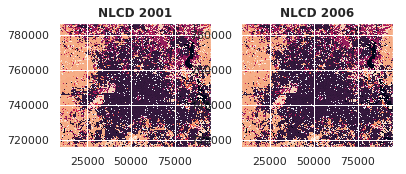

In [43]:
###########################################
###########################################
### PART I: READ AND VISUALIZE DATA #######
	
infile_land_cover_date1 = os.path.join(in_dir,infile_land_cover_date1) #NLCD 2001
infile_land_cover_date2 = os.path.join(in_dir,infile_land_cover_date2) #NLCD 2006
infile_land_cover_date3 = os.path.join(in_dir,infile_land_cover_date3) #NLCD 2011

lc_date1 = rasterio.open(infile_land_cover_date1) 
r_lc_date1 = lc_date1.read(1,masked=True) #read first array with masked value, nan are assigned for NA
lc_date2 = rasterio.open(infile_land_cover_date2) 
r_lc_date2 = lc_date2.read(1,masked=True) #read first array with masked value, nan are assigned for NA
lc_date3= rasterio.open(infile_land_cover_date2) 

#Generate quick visualization using rasterio object
f, ax = plt.subplots(1, 2)
plot.show(lc_date1,title="NLCD 2001",ax=ax[0])
plot.show(lc_date2,title="NLCD 2006",ax=ax[1])

print(type(lc_date1))
print("Coordinate reference system: ",lc_date1.crs ) 
      
print(" Rows and columns: ", lc_date1.shape, "number of rows: ", lc_date1.height)  

lc_legend_df = pd.read_csv(os.path.join(in_dir,infile_name_nlcd_legend),sep=",")
lc_legend_df.head() # Inspect data
lc_legend_df.columns
lc_legend_df.shape
#subset the data to remove unused rows
lc_legend_df = lc_legend_df[lc_legend_df['COUNT']>0] 


## PART 2: Analyze overall changes and land transitions

We analyze changes in the Houston area by comparing change in areas between the two dates (2001-2006). We can also examine the most common transitions between the land cover classes using crosstabulation. Before any analyses, we reclassifly the NLCD maps to simplify and generalizes the classes using NLCD Anderson level 1 classes.


In [ ]:
#######
################################################
###  PART II : Analyze overall changes and land transitions

## As the plot shows for 2006, we have 15 land cover types. Analyzing such complex categories in terms of decreasse (loss), increase (gain), 
## persistence in land cover will generate a large number of transitions (potential up to 15*15=225 transitions in this case!)
## To generalize the information, let's aggregate leveraging the hierachical nature of NLCD Anderson Classification system.

#### Step 1: aggregate NLCD classes

# Read in classification system: Now 15 land categories instead of 20.

lc_system_nlcd_df = pd.read_excel(os.path.join(in_dir,infile_name_nlcd_classification_system))
lc_system_nlcd_df.head() #inspect data

### Set up the reclassification
class_def = np.array([0,20,1,
                      20,30,2,
                      30,40,3,
                      40,50,4,
                      50,60,5,
                      60,70,6,
                      70,80,7,
                      80,90,8,
                      90,100,9])
 
class_def = class_def.reshape(9,3)

## Generate copies of raster objects
r_date1_rec = copy.copy(r_lc_date1)
r_date2_rec = copy.copy(r_lc_date2)

for i in np.arange(0,9):
    class_val = class_def[i,:]
    r_date1_rec[(class_val[0]<= r_date1_rec) & (r_date1_rec <class_val[1])] = class_val[2]
    r_date2_rec[(class_val[0]<= r_date2_rec) & (r_date2_rec <class_val[1])] = class_val[2]

f, ax = plt.subplots(1, 2)
plot.show(r_date1_rec,title="NLCD 2001 reclassified",ax=ax[0])
plot.show(r_date2_rec,title="NLCD 2006 reclassified",ax=ax[1])


## Examine overall changes in categories

We compute the frequency of each land cover classes for each NLCD map and generate a difference bewteen 2001 and 2006. We find that the most common change is an increase in urban areas. The largest decreases in the forest and herbaceous lands.


In [ ]:
####### Step 2: Examine overall changes in categories

val, cnts =np.unique(r_date1_rec,return_counts=True)
df = pd.DataFrame(np.ma.filled(val))
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_date1 = pd.DataFrame(val,cnts)
df_date1 = df_date1.reset_index()
df_date1.columns = ['y_2001','value']

val, cnts =np.unique(r_date2_rec,return_counts=True)
df = pd.DataFrame(np.ma.filled(val))
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_date2 = pd.DataFrame(val,cnts)
df_date2 = df_date2.reset_index()
df_date2.columns = ['y_2006','value']

### Let's identify existing cover and compute change:
freq_tb_nlcd = pd.merge(df_date1,df_date2,on='value')
#reorder columns 
freq_tb_nlcd = freq_tb_nlcd[['value','y_2001','y_2006']]
freq_tb_nlcd['diff'] = freq_tb_nlcd['y_2006'] - freq_tb_nlcd['y_2001']
## link to category names
cat_val = lc_system_nlcd_df[['id_l1','name_l1']].drop_duplicates()

freq_tb_nlcd = pd.merge(freq_tb_nlcd,
                        cat_val,
                        left_on='value',
                        right_on='id_l1')
freq_tb_nlcd

## barplot
sns.set(style="whitegrid")
#tips = ns.load_dataset("tips")
ax = sns.barplot(x="name_l1", 
                     y="diff", 
                     data=freq_tb_nlcd)
ax.set_xticklabels(list(freq_tb_nlcd["name_l1"]),rotation=30)


## Method 2: Summarize using groupby aggregation and joining

This method uses "groupby" to aggregation information by census track using a summary function. We use here "sum" to generate summary at the census track level. Note that the output of the gropuby operation is a pandas DataFrame. The output table is then join to the census track level geopanda DataFrame using the track ID as the primary key. Before joing the datasets, we must ensure that the datatypes of both keys match and change the column data type us "astype" if necessary. The join operation is carried out using the merge function. 


In [ ]:
##### Step 3: examine land transitions 
#### Crosstab

data_rec = pd.DataFrame({'date1': r_date1_rec.ravel(),
             'date2':

In [ ]:
 r_date2_rec.ravel()})
rec_xtab_df= pd.crosstab(data_rec['date1'],data_rec['date2'])

#rec_xtab_df['class'] = rec_xtab_df.index
rec_xtab_df.columns = ['1.0','2.0','3.0','4.0','5.0','7.0','8.0','9.0']
rec_xtab_df.index = ['1.0','2.0','3.0','4.0','5.0','7.0','8.0','9.0']
print(rec_xtab_df)

rec_xtab_df.max() # diagonal is the max for all columns

rec_xtab_df['2.0']

## Look at transitions for class 2 (urban)
## Most common is from 8 to 2
## Planted cultived to urban
## Second biggest is from FOrest (4) to 2

## PART III: Process and prepare for land cover change modeling

In this section, we read in the datasets that will be used in the logistic regression to predict urban change in Houston over the 2001-2006 time period. The variables were preprocessed and we extract values at every pixel location. The dataset includes the following relevant columns:
- change: boolean, 1 for change to urban and 0 for no change 
- land cover: potential land categories for change, some categories may be mores suitable for urban conversion (e.g. forest etc.) 
- slope: slope value in degrees, lower slope is more suitable for new urban areas 
- road_dist: distance to existing roads
- developed_dist: distance to existing urban areas (in 2001) 


In [ ]:
###########################################
############# PART III: Process and prepare for land change modeling ####################
## add this later

### Let's read in the information that contains variables
data_df = pd.read_csv(os.path.join(in_dir,data_fname))
data_df.columns
data_df.head()

## PART 3: SPATIAL QUERY 

We generate a dataset with metals and lead information by census tracks.
This requires multiple steps. First, we need to join metals attribute to census tracks. Second, we generate a spatial object from the textfile of lead (PB) data. This files contains x and y coordinates that can be used to create a POINT geometry column using the shapely and geopandas packages.
The third step consists in joining the lead data to census tracks. This is done through a spatial join to associate point data with polygons identifiers containing them. The fourth step consists in using a summarize by operation ("groupby") to generate averages of lead ppm by census tracks.


In [ ]:
################
##### Step 1: Prepare categorical features/covariates by rescaling values

## Relevant variables used:
selected_covariates_names = ['land_cover', 'slope', 'roads_dist', 'developped_dist']
selected_target_names = ['change'] #also called dependent variable

## We need to account for categorical versus continuous variables
selected_categorical_var_names=['land_cover']
selected_continuous_var_names=list(set(selected_covariates_names) - set(selected_categorical_var_names))
##Find frequency of unique values:
freq_val_df = data_df[selected_categorical_var_names].apply(pd.value_counts)
print(freq_val_df.head())
values_cat = array(data_df[selected_categorical_var_names].values) #note this is assuming only one cat val here

label_encoder = LabelEncoder()  # labeling categories
one_hot_encoder = OneHotEncoder(sparse=False) #generate dummy variables
### First integer encode:
integer_encoded = label_encoder.fit_transform(values_cat)
print(integer_encoded)
# Binary encode:
integer_encoded = integer_encoded.reshape(len(integer_encoded),1)
print(integer_encoded)

#33 generate dummy variables
onehot_encoded = one_hot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
onehot_encoded.shape
type(onehot_encoded)

#Check values generated: invert to check value?
onehot_encoded[0:5,]
values_cat[0:5,]
inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[1,:])])
print(inverted)

#assign back to the data.frame
unique_val = np.array(freq_val_df.index)
unique_val = np.sort(unique_val)
print(unique_val)
names_cat = ['lc_' + str(i) for i in unique_val]
print(names_cat)
onehot_encoded_df = pd.DataFrame(onehot_encoded,columns=names_cat)
onehot_encoded_df.columns
onehot_encoded_df.head()
onehot_encoded_df.shape
data_df.shape

## Add the new encoded variables to the data frame
data_df= pd.concat([data_df,onehot_encoded_df],sort=False,axis=1)
data_df.shape
data_df.head()

selected_covariates_names_updated = selected_continuous_var_names + names_cat 


In [ ]:
##############
## Step 2: Split training and testing and rescaling for continuous variables

X_train, X_test, y_train, y_test = train_test_split(data_df[selected_covariates_names_updated], 
                                                    data_df[selected_target_names], 
                                                    test_size=prop, 
                                                    random_state=random_seed)
X_train.shape
X_train.head()


In [ ]:
#### Scaling between 0-1 for continuous variables
# Data needs to be scaled to a small range like 0 to 1 for the neural
# network to work well.
scaler = MinMaxScaler(feature_range=(0, 1))
### need to select only the continuous var:
scaled_training = scaler.fit_transform(X_train[selected_continuous_var_names])
scaled_testing = scaler.transform(X_test[selected_continuous_var_names])
type(scaled_training) # array
scaled_training.shape

## Concatenate column-wise
X_testing_df = pd.DataFrame(np.concatenate((X_test[names_cat].values,scaled_testing),axis=1),
                                            columns=names_cat+selected_continuous_var_names)

X_training_df = pd.DataFrame(np.concatenate((X_train[names_cat].values,scaled_training),axis=1),
                                            columns=names_cat+selected_continuous_var_names)
X_training_df.head()


## PART IV: Spatial regression: Vulnerability to metals 

In this section, we examine the relationship between lead and vulnerable populations in Syracuse using first a linear OLS regression and then a spatial lag regression model. Spatial datasets often contain autocorrelation and this must be taken into account when regression models are performed. In the first step, we explor the neighbor structure of the dataset using pysal objects.  In the econd step, we explore spatial autocorrelation using the Moran's I index.


In [ ]:
###########################################
### PART IV: Run model and perform assessment ###########################

####################
###### Step 1: fit glm logistic model and generate predictions

model_logistic = LogisticRegression() #instantiate model object
model_logistic = model_logistic.fit(X_train.values,y_train.values.ravel())

print("model coefficients: ",model_logistic.coef_)
selected_covariates_names_updated

pred_test_prob = model_logistic.predict_proba(X_test.values)
y_scores_test = pred_test_prob[:,1]
pred_train_prob = model_logistic.predict_proba(X_train.values)
y_scores_train = pred_train_prob[:,1]

### Note that we only have about 10% change in the dataset so setting 50% does not make sense!!
sum(data_df.change)/data_df.shape[0]
sum(y_train.change)/y_train.shape[0]
sns.set(color_codes=True) #improves layout with bar and background grid
sns.countplot(x='change',data=data_df)
plt.show()
plt.savefig('count_plot')




In [ ]:
# Explore values distribution
f, ax = plt.subplots(1, 2)
sns.distplot(y_scores_train,ax=ax[0])#title='January residuals')
sns.distplot(y_scores_test,ax=ax[1])#title='January residuals')
ax[0].set(title="Predicted training probabilities") 
ax[1].set(title="Predicted testing probabilities") 


In [ ]:
####################
###### Step 2: Model assessment with ROC and AUC

#Compute AUC
auc_val_train =roc_auc_score(y_train,y_scores_train)
auc_val_test =roc_auc_score(y_test,y_scores_test)

print("AUC train: ", auc_val_train)
print("AUC test: ", auc_val_test)

#Generate inputs for ROC curves
fpr, tpr, thresholds = roc_curve(y_test, 
                                 y_scores_test)
plt.figure()
plt.plot(fpr, tpr, 
         label='Logistic Regression (area = %0.2f)' % auc_val_test)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

###################### END OF SCRIPT #####################

## Conclusions

In this study, we examined urban land cover change in Houston for the county of Harris. We reported on the general patterns of gains and losses in categories and found that urban change was the most important gain while forest and herbaceous surfaces showed the most important losses over the 2001-2006 time period. We found that these two categories were also the most common transition pathway to become urban. We used four explanatory variables to predict a change/no change boolean variable using the logistic model. The variables are commonly used in simple land cover change model and include distance to road, distance to existing urban, slope and land cover types. After rescaling coutinuous variables and generating dummy variables for the land cover types, we split training and testing data using a 30% hold out. Results were asssed using the ROC and AUC metrics. We found an 0.75 AUC for both training and testing.

## References

PySAL: A Python Library of Spatial Analytical Methods, Rey, S.J. and L. Anselin, Review of Regional Studies 37, 5-27 2007.

Moran, P. A. P. (1950). "Notes on Continuous Stochastic Phenomena". Biometrika. 37 (1): 17–23. doi:10.2307/2332142. JSTOR 2332142.

Impacts of positional error on spatial regression analysis: a case study of address locations in Syracuse, New York. DA Griffith, M Millones, M Vincent, DL Johnson, A Hunt - Transactions in GIS, 2007

Cliff and Ord (1981), Spatial Processes, London
